In [1]:
cd /opt/ml/code

/opt/ml/code


In [2]:
import random
import json

import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from utils_modified import label_accuracy_score, add_hist

import cv2

import numpy as np
import pandas as pd

from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import timeit

print(f'pytorch version: {torch.__version__}')
print(f'GPU 사용 가능 여부: {torch.cuda.is_available()}')
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pytorch version: 1.7.1
GPU 사용 가능 여부: True
Tesla P40
1


In [3]:
def set_seed(seed=21):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
    #torch.set_deterministic(True)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [4]:
def EDA():
    with open(anns_file_path, 'r') as f:
        dataset = json.loads(f.read())

    categories = dataset['categories']
    anns = dataset['annotations']
    imgs = dataset['images']
    nr_cats = len(categories)
    nr_annotations = len(anns)
    nr_images = len(imgs)

    cat_names = []
    super_cat_names = []
    super_cat_ids = {}
    super_cat_last_name = ''
    nr_super_cats = 0
    for cat_it in categories:
        cat_names.append(cat_it['name'])
        super_cat_name = cat_it['supercategory']
        if super_cat_name != super_cat_last_name:
            super_cat_names.append(super_cat_name)
            super_cat_ids[super_cat_name] = nr_super_cats
            nr_super_cats += 1
    print('Number of super categories:', nr_super_cats)
    print('Number of categories:', nr_cats)
    print('Number of annotations:', nr_annotations)
    print('Number of images:', nr_images)

    cat_histogram = np.zeros(nr_cats, dtype=int)
    for ann_it in anns:
        cat_histogram[ann_it['category_id']] += 1

    f, ax = plt.subplots(figsize=(5, 5))
    df = pd.DataFrame({'Categories': cat_names, 'Number of annotations':cat_histogram})

    plt.title('category distribution of train set')
    sns.barplot(x='Number of annotations', y='Categories', data=df.sort_values('Number of annotations', ascending=False), label='Total', color='b')
    plt.show()

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, transform):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
    
    def __getitem__(self, index:int):
        image_infos = self.coco.loadImgs(index)[0]

        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        #images /= 255.0

        if self.mode in ('train', 'val'):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            masks = np.zeros((image_infos['height'], image_infos['width']))
            for ann in anns:
                masks = np.maximum(self.coco.annToMask(ann) * ann['category_id'], masks)
            
            images, masks = self.transform(image=images, mask=masks).values()
            return images, masks, image_infos
        
        if self.mode == 'test':
            images = self.transform(image=images)['image']
            return images, image_infos

    def __len__(self) -> int:
        return len(self.coco.getImgIds())

In [6]:
def get_dataloader():
    train_dataset = CustomDataset(data_dir=train_path, mode='train',transform=train_transform)
    val_dataset = CustomDataset(data_dir=val_path, mode='val', transform=val_transform)
    test_dataset = CustomDataset(data_dir=test_path, mode='test', transform=test_transform)

    def collate_fn(batch):
        return tuple(zip(*batch))

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=4,
                                            collate_fn=collate_fn,
                                            drop_last=True,
                                            worker_init_fn=seed_worker)

    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=4,
                                            collate_fn=collate_fn,
                                            worker_init_fn=seed_worker)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            num_workers=4,
                                            collate_fn=collate_fn,
                                            worker_init_fn=seed_worker)
    return train_loader, val_loader, test_loader

In [7]:
def test_dataloader(dataloader):
    data = iter(dataloader).next()
    if len(data) == 3:
        imgs, masks, image_infos = data
        img = imgs[0]
        mask = masks[0]
        image_info = image_infos[0]

        fig, axes = plt.subplots(1, 2, figsize=(12, 12))
        print('image shape:', list(img.shape))
        print('mask shape:', list(mask.shape))
        print('Unique values, category of transformed mask:\n', {int(i):category_names[int(i)] for i in list(np.unique(mask))})

        axes[0].imshow(img.permute([1, 2, 0]))
        axes[0].grid(False)
        axes[0].set_title('imput image:' + str(image_info['file_name']), fontsize=15)

        axes[1].imshow(mask)
        axes[1].grid(False)
        axes[1].set_title('masks :' + str(image_info['file_name']), fontsize=15)

        plt.show()
    elif len(data) == 2:
        imgs, image_infos = iter(dataloader).next()
        img = imgs[0]
        image_info = image_infos[0]

        fig, ax = plt.subplots(figsize=(6, 6))
        print('image shape:', list(img.shape))

        ax.imshow(img.permute([1, 2, 0]))
        ax.grid(False)
        ax.set_title('imput image:' + str(image_info['file_name']), fontsize=15)

        plt.show()

In [8]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device, print_log=True):
    if print_log:
        print('Start training')
    best_mIoU = 0
    hist_mIoU = []
    epoch_begin = 0

    name = str(type(model.encoder)).split('.')[-1]
    name += ' ' + str(type(model.decoder)).split('.')[-1]

    for epoch in tqdm(range(0, num_epochs), desc=name):
        model.train()
        for step, (images, masks, _) in tqdm(enumerate(data_loader), desc='Training', leave=False, total=len(data_loader)):
            images = torch.stack(images).to(device)
            masks = torch.stack(masks).long().to(device)
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if print_log:
                if (step + 1) % 25 == 0:
                    print(f'Epoch[{epoch + 1}/{num_epochs}], Step[{step + 1}/{len(data_loader)}], Loss: {loss.item():.4f}')
                    
        if (epoch + 1) % val_every == 0:
            mIoU = validation(epoch + 1, model, val_loader, criterion, device, print_log)
            hist_mIoU.append(mIoU)
            if mIoU > best_mIoU:
                if print_log:
                    print(f'Best performance at epoch: {epoch + 1}')
                    print('Save model in', saved_dir)
                best_mIoU = mIoU
                save_model(model, saved_dir)

    return hist_mIoU

In [9]:
def validation(epoch, model, data_loader, criterion, device, print_log=True):
    if print_log:
        print(f'Start validation #{epoch}')
    model.eval()
    with torch.no_grad():
        hist = np.zeros((N_CLASSES, N_CLASSES))
        for step, (images, masks, _) in tqdm(enumerate(data_loader), desc='Validation', leave=False, total=len(data_loader)):
            images = torch.stack(images).to(device)
            masks = torch.stack(masks).long().to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)

            outputs = torch.argmax(outputs.squeeze(), dim=1)
            outputs = outputs.detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            hist = add_hist(hist, masks, outputs, n_class=N_CLASSES)
        
        acc, acc_cls, mIoU, fwavacc = label_accuracy_score(hist)
        if print_log:
            print(f'Validation #{epoch} mIoU: {mIoU:.4f}')
    return mIoU

In [10]:
def save_model(model, saved_dir):
    file_name = f'{model_name}.pt'
    os.makedirs(saved_dir, exist_ok=True)
    check_point = {'net':model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

In [30]:
def load_model(model_name, model):
    model_path = saved_path + f'/{model_name}.pt'
    checkpoint = torch.load(model_path, map_location=device)
    model = model.load_state_dict(checkpoint)
    return model

In [37]:
def test_eval_model(model, dataloader, idx=0):
    for imgs, image_infos in dataloader:
        model.eval()
        outs = model(torch.stack(imgs).to(device))
        outs = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
        break

    imgs = imgs[idx]
    image_infos = image_infos[idx]
    outs = outs[idx]

    fig, axes = plt.subplots(1, 2, figsize=(16, 16))
    print('Shape of Original Image:', list(imgs.shape))
    print('Shape of Predicted:', list(outs.shape))
    print('Unique values, category of transformed mask\n', {int(i):category_names[int(i)] for i in list(np.unique(outs))})

    axes[0].imshow(imgs.permute([1,2,0]))
    axes[0].grid(False)
    axes[0].set_title('Original image:' + str(image_infos['file_name']), fontsize=15)

    axes[1].imshow(outs)
    axes[1].grid(False)
    axes[1].set_title('Predicted:' + str(image_infos['file_name']), fontsize=15)

    plt.show()

In [23]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction')
    print(model, type(model))
    model.eval()

    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in tqdm(enumerate(data_loader)):
            outs = model(torch.stack(imgs).to(device))
            outs = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()

            masks = []
            for img, mask in zip(np.stack(imgs), outs):
                img, mask = transform(image=img, mask=mask).values()
                masks.append(mask)
            outs = np.array(masks)
            outs = outs.reshape([outs.shape[0], size * size]).astype(int)
            preds_array = np.vstack((preds_array, outs))

            file_name_list.append([i['file_name'] for i in image_infos])
    print('End prediction.')
    file_names = [y for x in file_name_list for y in x]
    return file_names, preds_array

In [14]:
def make_submission(model, dataloader):
    submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)
    file_names, preds = test(model, dataloader, device)

    for file_name, string in zip(file_names, preds):
        submission = submission.append({'image_id':file_name, 'PredictionString':' '.join(str(e) for e in string.tolist())}, ignore_index=True)

    submission.to_csv(submission_path + f'/{model_name}.csv', index=False)

In [44]:
N_CLASSES = 12
batch_size = 8
num_epochs = 8
image_size = 256
learning_rate = 0.0001
model_name = 'prev'
random_seed = 21
val_every = 1

set_seed(random_seed)

model = smp.DeepLabV3Plus(
    encoder_name="resnext50_32x4d",
    encoder_weights="imagenet",
    in_channels=3,
    classes=N_CLASSES,
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-6)

train_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
    ),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomRotate90(),
    A.OneOf([
        A.MotionBlur(p=1.0),
        A.OpticalDistortion(p=1.0)
    ], p=2/3),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
    ),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
    ),
    ToTensorV2()
])

dataset_path = '../input/data'
anns_file_path = dataset_path + '/train.json'
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'
saved_path = './saved'
submission_path = './submission'
category_names = ['Background','UNKNOWN','General trash','Paper','Paper pack','Metal','Glass','Plastic','Styrofoam','Plastic bag','Battery','Clothing']


In [45]:
train_loader, val_loader, test_loader = get_dataloader()

loading annotations into memory...
Done (t=3.89s)
creating index...
index created!
loading annotations into memory...
Done (t=1.59s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [46]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_path, val_every, device)

Start training


ResNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch[1/8], Step[25/327], Loss: 1.8191
Epoch[1/8], Step[50/327], Loss: 1.1756
Epoch[1/8], Step[75/327], Loss: 1.0408
Epoch[1/8], Step[100/327], Loss: 0.7871
Epoch[1/8], Step[125/327], Loss: 0.7308
Epoch[1/8], Step[150/327], Loss: 0.7012
Epoch[1/8], Step[175/327], Loss: 0.6502
Epoch[1/8], Step[200/327], Loss: 0.7493
Epoch[1/8], Step[225/327], Loss: 0.7362
Epoch[1/8], Step[250/327], Loss: 0.6598
Epoch[1/8], Step[275/327], Loss: 0.6117
Epoch[1/8], Step[300/327], Loss: 0.5613
Epoch[1/8], Step[325/327], Loss: 0.8242
Start validation #1


Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Validation #1 mIoU: 0.3358
Best performance at epoch: 1
Save model in ./saved


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch[2/8], Step[25/327], Loss: 0.9253
Epoch[2/8], Step[50/327], Loss: 0.4956
Epoch[2/8], Step[75/327], Loss: 0.4155
Epoch[2/8], Step[100/327], Loss: 0.5051
Epoch[2/8], Step[125/327], Loss: 0.7669
Epoch[2/8], Step[150/327], Loss: 0.4845
Epoch[2/8], Step[175/327], Loss: 0.3769
Epoch[2/8], Step[200/327], Loss: 0.4761
Epoch[2/8], Step[225/327], Loss: 0.3574
Epoch[2/8], Step[250/327], Loss: 0.3759
Epoch[2/8], Step[275/327], Loss: 0.6690
Epoch[2/8], Step[300/327], Loss: 0.5514
Epoch[2/8], Step[325/327], Loss: 0.5435
Start validation #2


Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Validation #2 mIoU: 0.4020
Best performance at epoch: 2
Save model in ./saved


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch[3/8], Step[25/327], Loss: 0.2779
Epoch[3/8], Step[50/327], Loss: 0.3474
Epoch[3/8], Step[75/327], Loss: 0.5420
Epoch[3/8], Step[100/327], Loss: 0.2722
Epoch[3/8], Step[125/327], Loss: 0.2383
Epoch[3/8], Step[150/327], Loss: 0.3543
Epoch[3/8], Step[175/327], Loss: 0.5109
Epoch[3/8], Step[200/327], Loss: 0.3684
Epoch[3/8], Step[225/327], Loss: 0.4807
Epoch[3/8], Step[250/327], Loss: 0.6954
Epoch[3/8], Step[275/327], Loss: 0.3817
Epoch[3/8], Step[300/327], Loss: 0.2427
Epoch[3/8], Step[325/327], Loss: 0.5221
Start validation #3


Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Validation #3 mIoU: 0.4034
Best performance at epoch: 3
Save model in ./saved


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch[4/8], Step[25/327], Loss: 0.8702
Epoch[4/8], Step[50/327], Loss: 0.6725
Epoch[4/8], Step[75/327], Loss: 0.3878
Epoch[4/8], Step[100/327], Loss: 0.4924
Epoch[4/8], Step[125/327], Loss: 0.3983
Epoch[4/8], Step[150/327], Loss: 0.3193
Epoch[4/8], Step[175/327], Loss: 0.3532
Epoch[4/8], Step[200/327], Loss: 0.2743
Epoch[4/8], Step[225/327], Loss: 0.2656
Epoch[4/8], Step[250/327], Loss: 0.3659
Epoch[4/8], Step[275/327], Loss: 0.4657
Epoch[4/8], Step[300/327], Loss: 0.2611
Epoch[4/8], Step[325/327], Loss: 0.4802
Start validation #4


Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Validation #4 mIoU: 0.4431
Best performance at epoch: 4
Save model in ./saved


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch[5/8], Step[25/327], Loss: 0.2417
Epoch[5/8], Step[50/327], Loss: 0.5139
Epoch[5/8], Step[75/327], Loss: 0.2250
Epoch[5/8], Step[100/327], Loss: 0.4413
Epoch[5/8], Step[125/327], Loss: 0.2819
Epoch[5/8], Step[150/327], Loss: 0.3061
Epoch[5/8], Step[175/327], Loss: 0.3153
Epoch[5/8], Step[200/327], Loss: 0.1976
Epoch[5/8], Step[225/327], Loss: 0.3357
Epoch[5/8], Step[250/327], Loss: 0.2831
Epoch[5/8], Step[275/327], Loss: 0.4299
Epoch[5/8], Step[300/327], Loss: 0.2962
Epoch[5/8], Step[325/327], Loss: 0.2928
Start validation #5


Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Validation #5 mIoU: 0.4493
Best performance at epoch: 5
Save model in ./saved


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch[6/8], Step[25/327], Loss: 0.3451
Epoch[6/8], Step[50/327], Loss: 0.2441
Epoch[6/8], Step[75/327], Loss: 0.2845
Epoch[6/8], Step[100/327], Loss: 0.2924
Epoch[6/8], Step[125/327], Loss: 0.7603
Epoch[6/8], Step[150/327], Loss: 0.2647
Epoch[6/8], Step[175/327], Loss: 0.3197
Epoch[6/8], Step[200/327], Loss: 0.4218
Epoch[6/8], Step[225/327], Loss: 0.3195
Epoch[6/8], Step[250/327], Loss: 0.3339
Epoch[6/8], Step[275/327], Loss: 0.6486
Epoch[6/8], Step[300/327], Loss: 0.2784
Epoch[6/8], Step[325/327], Loss: 0.2193
Start validation #6


Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Validation #6 mIoU: 0.4410


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch[7/8], Step[25/327], Loss: 0.1272
Epoch[7/8], Step[50/327], Loss: 0.4037
Epoch[7/8], Step[75/327], Loss: 0.2393
Epoch[7/8], Step[100/327], Loss: 0.3087
Epoch[7/8], Step[125/327], Loss: 0.1404
Epoch[7/8], Step[150/327], Loss: 0.2072
Epoch[7/8], Step[175/327], Loss: 0.5400
Epoch[7/8], Step[200/327], Loss: 0.2588
Epoch[7/8], Step[225/327], Loss: 0.3203
Epoch[7/8], Step[250/327], Loss: 0.2934
Epoch[7/8], Step[275/327], Loss: 0.3789
Epoch[7/8], Step[300/327], Loss: 0.1895
Epoch[7/8], Step[325/327], Loss: 0.4323
Start validation #7


Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Validation #7 mIoU: 0.4487


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch[8/8], Step[25/327], Loss: 0.4400
Epoch[8/8], Step[50/327], Loss: 0.2170
Epoch[8/8], Step[75/327], Loss: 0.3874
Epoch[8/8], Step[100/327], Loss: 0.1190
Epoch[8/8], Step[125/327], Loss: 0.3663
Epoch[8/8], Step[150/327], Loss: 0.1955
Epoch[8/8], Step[175/327], Loss: 0.2558
Epoch[8/8], Step[200/327], Loss: 0.2299
Epoch[8/8], Step[225/327], Loss: 0.1810
Epoch[8/8], Step[250/327], Loss: 0.2116
Epoch[8/8], Step[275/327], Loss: 0.2086
Epoch[8/8], Step[300/327], Loss: 0.1571
Epoch[8/8], Step[325/327], Loss: 0.3195
Start validation #8


Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Validation #8 mIoU: 0.4584
Best performance at epoch: 8
Save model in ./saved


[0.3358047492812337,
 0.40199983248066046,
 0.4033713460940437,
 0.44314831435838326,
 0.4492590692895939,
 0.44104316422758355,
 0.44873782452834415,
 0.45836411618509987]

In [47]:
model_path = saved_path + f'/{model_name}.pt'
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)
#model = load_model(model_name, model)
make_submission(model, test_loader)

Start prediction
DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=Tru

0it [00:00, ?it/s]

End prediction.


## 테스트 함수

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Shape of Original Image: [3, 256, 256]
Shape of Predicted: [256, 256]
Unique values, category of transformed mask
 {0: 'Background', 2: 'General trash', 8: 'Styrofoam'}


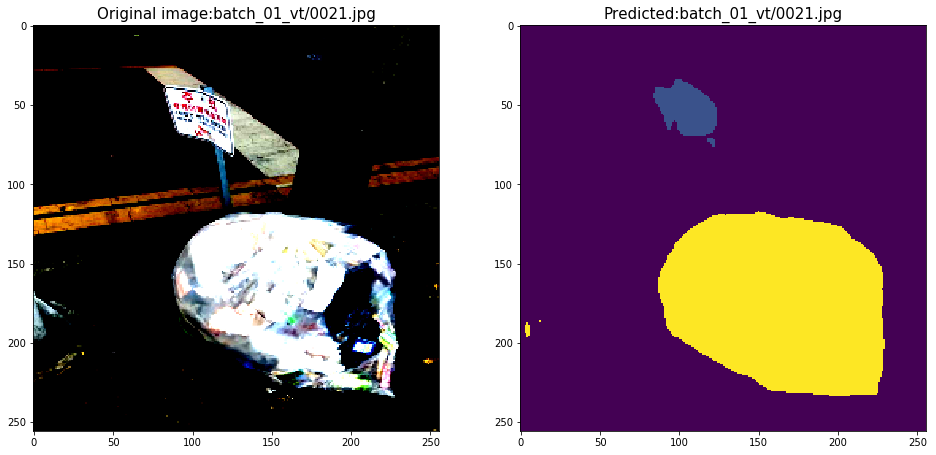

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Shape of Original Image: [3, 256, 256]
Shape of Predicted: [256, 256]
Unique values, category of transformed mask
 {0: 'Background', 2: 'General trash', 6: 'Glass', 8: 'Styrofoam'}


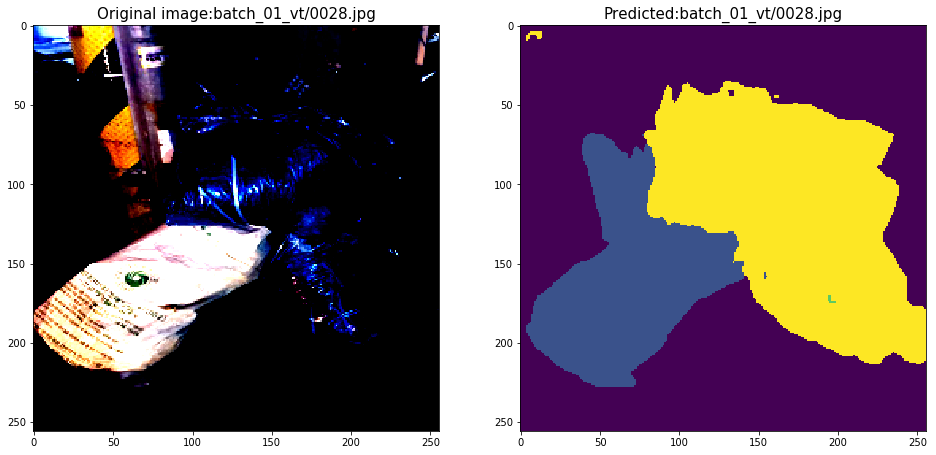

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Shape of Original Image: [3, 256, 256]
Shape of Predicted: [256, 256]
Unique values, category of transformed mask
 {0: 'Background', 1: 'UNKNOWN'}


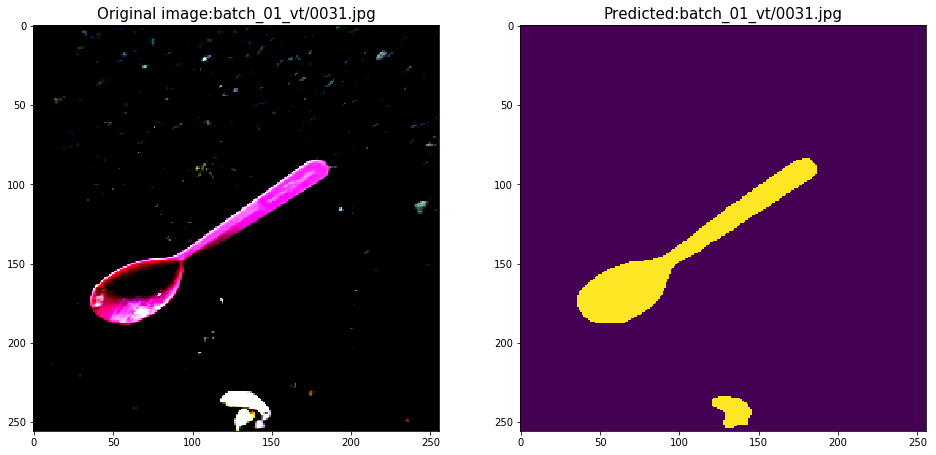

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Shape of Original Image: [3, 256, 256]
Shape of Predicted: [256, 256]
Unique values, category of transformed mask
 {0: 'Background', 8: 'Styrofoam'}


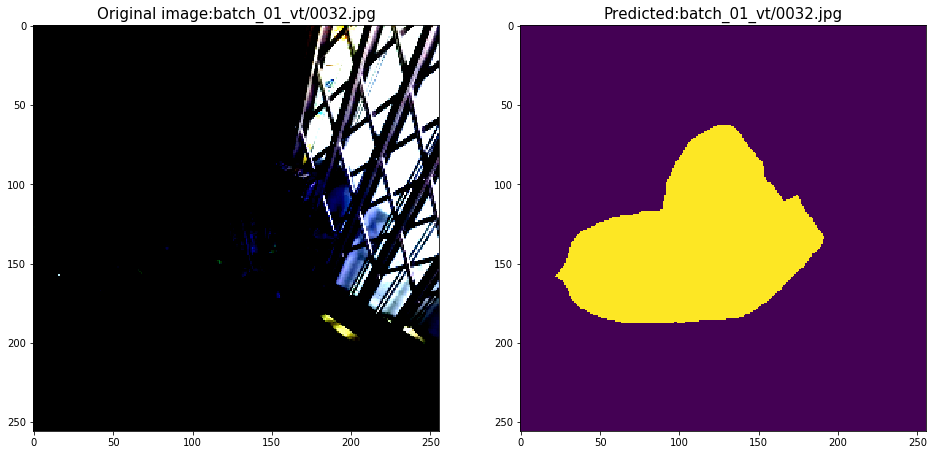

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Shape of Original Image: [3, 256, 256]
Shape of Predicted: [256, 256]
Unique values, category of transformed mask
 {0: 'Background', 2: 'General trash', 6: 'Glass', 7: 'Plastic', 8: 'Styrofoam'}


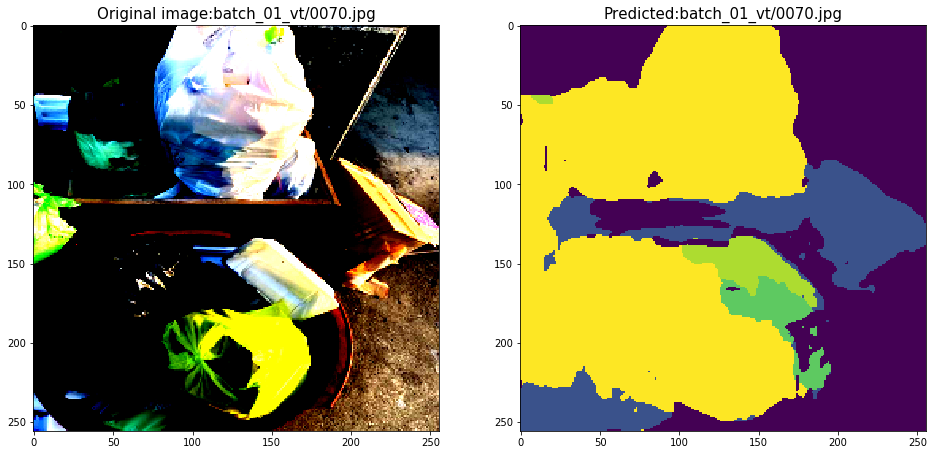

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Shape of Original Image: [3, 256, 256]
Shape of Predicted: [256, 256]
Unique values, category of transformed mask
 {0: 'Background', 8: 'Styrofoam'}


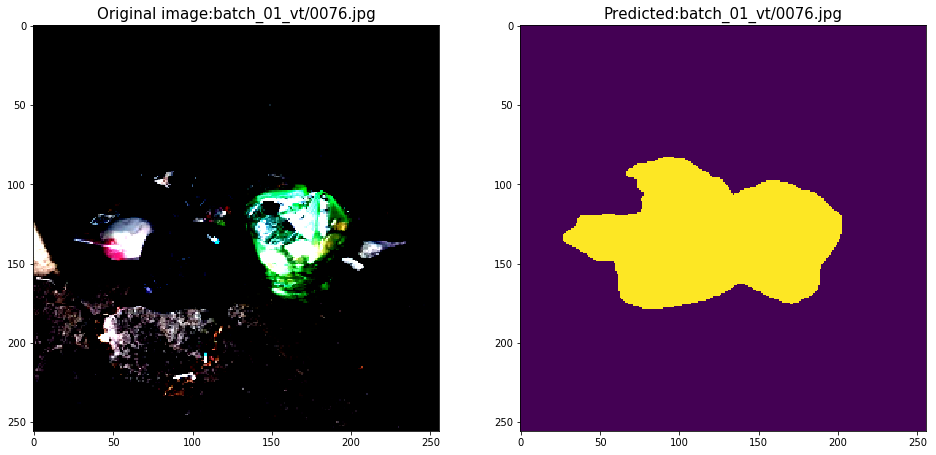

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Shape of Original Image: [3, 256, 256]
Shape of Predicted: [256, 256]
Unique values, category of transformed mask
 {0: 'Background', 8: 'Styrofoam'}


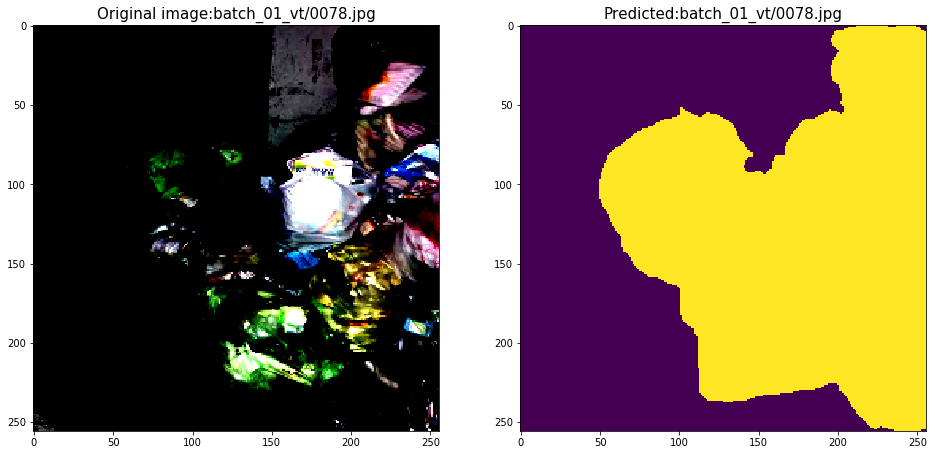

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Shape of Original Image: [3, 256, 256]
Shape of Predicted: [256, 256]
Unique values, category of transformed mask
 {0: 'Background', 6: 'Glass'}


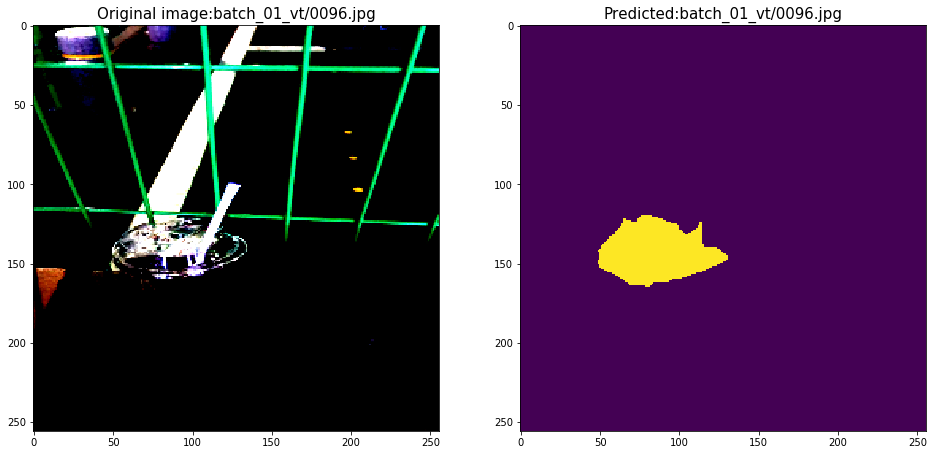

In [49]:
for i in range(batch_size):
    test_eval_model(model, test_loader, i)

In [53]:
encoder_list = [
    #'resnet18',
    #'resnet34',
    #'resnet50',
    #'resnet101',
    #'resnext50_32x4d',
    #'timm-resnest14d',
    #'timm-resnest26d',
    #'timm-resnest50d',
    #'timm-resnest101e',
    #'timm-resnest50d_4s2x40d',
    #'timm-resnest50d_1s4x24d',
    #'timm-res2net50_26w_4s',
    #'timm-res2net101_26w_4s',
    #'timm-res2net50_26w_6s',
    #'timm-res2net50_26w_8s',
    #'timm-res2net50_48w_2s',
    #'timm-res2net50_14w_8s',
    #'timm-res2next50',
    #'timm-regnetx_002',
    #'timm-regnetx_004',
    #'timm-regnetx_006',
    #'timm-regnetx_008',
    #'timm-regnetx_016',
    #'timm-regnetx_032',
    #'timm-regnetx_040',
    #'timm-regnetx_064',
    #'timm-regnetx_080',
    #'timm-regnetx_120',
    'timm-regnety_002',
    'timm-regnety_004',
    'timm-regnety_006',
    'timm-regnety_008',
    'timm-regnety_016',
    'timm-regnety_032',
    'timm-regnety_040',
    'timm-regnety_064',
    'timm-regnety_080',
    'timm-regnety_120',
    'se_resnet50',
    'se_resnet101',
    'se_resnext50_32x4d',
    'se_resnext101_32x4d',
    'timm-skresnet18',
    'timm-skresnet34',
    'timm-skresnext50_32x4d',
    'densenet121',
    'densenet169',
    'densenet201',
    'densenet161',
    'inceptionv4',
    'xception',
    'efficientnet-b0',
    'efficientnet-b1',
    'efficientnet-b2',
    'efficientnet-b3',
    'efficientnet-b4',
    'efficientnet-b5',
    'efficientnet-b6',
    'timm-efficientnet-b0',
    'timm-efficientnet-b1',
    'timm-efficientnet-b2',
    'timm-efficientnet-b3',
    'timm-efficientnet-b4',
    'timm-efficientnet-b5',
    'timm-efficientnet-b6',
    'timm-efficientnet-lite0',
    'timm-efficientnet-lite1',
    'timm-efficientnet-lite2',
    'timm-efficientnet-lite3',
    'timm-efficientnet-lite4',
    'mobilenet_v2',
    'dpn68',
    'vgg11',
    'vgg11_bn',
    'vgg13',
    'vgg13_bn',
    'vgg16',
    'vgg16_bn',
    'vgg19',
    'vgg19_bn'
]
decoder_list = [
    'DeepLabV3Plus'
]

In [60]:
def model_test(encoder_list, decoder_list):
    model_test_result = []
    for encoder in encoder_list:
        for  decoder in decoder_list:
            set_seed(random_seed)
            try:
                if decoder == 'DeepLabV3Plus':
                    model = smp.DeepLabV3Plus(
                        encoder_name=encoder,
                        encoder_weights="imagenet",
                        in_channels=3,
                        classes=N_CLASSES,
                    )
                else:
                    raise 'decoder does not exist'
                criterion = nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-6)
                model = model.to(device)
                start_time = timeit.default_timer()
                mIoU = train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_path, val_every, device, print_log=False)
                end_time = timeit.default_timer()
                time = end_time - start_time
                stat = {'encoder' : encoder, 'decoder' : decoder, 'mIoU' : mIoU, 'time' : time}
            except Exception as e:
                stat = {'encoder' : encoder, 'decoder' : decoder, 'error' : e}
                pass
            print(stat)
            model_test_result.append(stat)
    return model_test_result

In [61]:
model_test(encoder_list, decoder_list)

{'encoder': 'timm-resnest14d', 'decoder': 'DeepLabV3Plus', 'error': ValueError('ResNest encoders do not support dilated mode')}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/gluon_resnest26-50eb607c.pth" to /opt/ml/.cache/torch/hub/checkpoints/gluon_resnest26-50eb607c.pth


  0%|          | 0.00/65.3M [00:00<?, ?B/s]

{'encoder': 'timm-resnest26d', 'decoder': 'DeepLabV3Plus', 'error': ValueError('ResNest encoders do not support dilated mode')}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50-528c19ca.pth" to /opt/ml/.cache/torch/hub/checkpoints/resnest50-528c19ca.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

{'encoder': 'timm-resnest50d', 'decoder': 'DeepLabV3Plus', 'error': ValueError('ResNest encoders do not support dilated mode')}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest101-22405ba7.pth" to /opt/ml/.cache/torch/hub/checkpoints/resnest101-22405ba7.pth


  0%|          | 0.00/185M [00:00<?, ?B/s]

{'encoder': 'timm-resnest101e', 'decoder': 'DeepLabV3Plus', 'error': ValueError('ResNest encoders do not support dilated mode')}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50_fast_4s2x40d-41d14ed0.pth" to /opt/ml/.cache/torch/hub/checkpoints/resnest50_fast_4s2x40d-41d14ed0.pth


  0%|          | 0.00/116M [00:00<?, ?B/s]

{'encoder': 'timm-resnest50d_4s2x40d', 'decoder': 'DeepLabV3Plus', 'error': ValueError('ResNest encoders do not support dilated mode')}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50_fast_1s4x24d-d4a4f76f.pth" to /opt/ml/.cache/torch/hub/checkpoints/resnest50_fast_1s4x24d-d4a4f76f.pth


  0%|          | 0.00/98.3M [00:00<?, ?B/s]

{'encoder': 'timm-resnest50d_1s4x24d', 'decoder': 'DeepLabV3Plus', 'error': ValueError('ResNest encoders do not support dilated mode')}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-res2net/res2net50_26w_4s-06e79181.pth" to /opt/ml/.cache/torch/hub/checkpoints/res2net50_26w_4s-06e79181.pth


  0%|          | 0.00/98.3M [00:00<?, ?B/s]

{'encoder': 'timm-res2net50_26w_4s', 'decoder': 'DeepLabV3Plus', 'error': ValueError('Res2Net encoders do not support dilated mode')}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-res2net/res2net101_26w_4s-02a759a1.pth" to /opt/ml/.cache/torch/hub/checkpoints/res2net101_26w_4s-02a759a1.pth


  0%|          | 0.00/173M [00:00<?, ?B/s]

{'encoder': 'timm-res2net101_26w_4s', 'decoder': 'DeepLabV3Plus', 'error': ValueError('Res2Net encoders do not support dilated mode')}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-res2net/res2net50_26w_6s-19041792.pth" to /opt/ml/.cache/torch/hub/checkpoints/res2net50_26w_6s-19041792.pth


  0%|          | 0.00/142M [00:00<?, ?B/s]

{'encoder': 'timm-res2net50_26w_6s', 'decoder': 'DeepLabV3Plus', 'error': ValueError('Res2Net encoders do not support dilated mode')}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-res2net/res2net50_26w_8s-2c7c9f12.pth" to /opt/ml/.cache/torch/hub/checkpoints/res2net50_26w_8s-2c7c9f12.pth


  0%|          | 0.00/185M [00:00<?, ?B/s]

{'encoder': 'timm-res2net50_26w_8s', 'decoder': 'DeepLabV3Plus', 'error': ValueError('Res2Net encoders do not support dilated mode')}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-res2net/res2net50_48w_2s-afed724a.pth" to /opt/ml/.cache/torch/hub/checkpoints/res2net50_48w_2s-afed724a.pth


  0%|          | 0.00/96.7M [00:00<?, ?B/s]

{'encoder': 'timm-res2net50_48w_2s', 'decoder': 'DeepLabV3Plus', 'error': ValueError('Res2Net encoders do not support dilated mode')}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-res2net/res2net50_14w_8s-6527dddc.pth" to /opt/ml/.cache/torch/hub/checkpoints/res2net50_14w_8s-6527dddc.pth


  0%|          | 0.00/96.0M [00:00<?, ?B/s]

{'encoder': 'timm-res2net50_14w_8s', 'decoder': 'DeepLabV3Plus', 'error': ValueError('Res2Net encoders do not support dilated mode')}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-res2net/res2next50_4s-6ef7e7bf.pth" to /opt/ml/.cache/torch/hub/checkpoints/res2next50_4s-6ef7e7bf.pth


  0%|          | 0.00/94.4M [00:00<?, ?B/s]

{'encoder': 'timm-res2next50', 'decoder': 'DeepLabV3Plus', 'error': ValueError('Res2Net encoders do not support dilated mode')}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_002-e7e85e5c.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnetx_002-e7e85e5c.pth


  0%|          | 0.00/10.4M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnetx_002', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.2272733483750103, 0.31393052224735124, 0.3613404299581946, 0.3803617322161159, 0.40404595059748954, 0.41860393733529033, 0.41312273907292424, 0.40899207116311403], 'time': 1139.8078939430416}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_004-7d0e9424.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnetx_004-7d0e9424.pth


  0%|          | 0.00/19.9M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnetx_004', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.2617444621307326, 0.3408115950644144, 0.4009770846249501, 0.4002820078998211, 0.42723563301991996, 0.43434230318851824, 0.436622931140246, 0.42904293639408575], 'time': 1170.9481807129923}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_006-85ec1baa.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnetx_006-85ec1baa.pth


  0%|          | 0.00/23.8M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnetx_006', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.2665535584485949, 0.33424323197964134, 0.40294014210499074, 0.4229263263769264, 0.4349793157197075, 0.43317300205044035, 0.4340569670211247, 0.44566551219045], 'time': 860.6857780239079}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_008-d8b470eb.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnetx_008-d8b470eb.pth


  0%|          | 0.00/27.9M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnetx_008', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.261065354529321, 0.36499848947785196, 0.4059206935507001, 0.4183558798671841, 0.4441553242283019, 0.4258721556226565, 0.43442807488591095, 0.45035430170451884], 'time': 1007.142520188936}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_016-65ca972a.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnetx_016-65ca972a.pth


  0%|          | 0.00/35.3M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnetx_016', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.29847328886043617, 0.3846431611389099, 0.44875389317215447, 0.44294541761692463, 0.4488932057145702, 0.455031276607782, 0.4667909515254158, 0.4664099623632039], 'time': 765.0524481380126}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_032-ed0c7f7e.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnetx_032-ed0c7f7e.pth


  0%|          | 0.00/58.7M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnetx_032', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.2994611860393452, 0.39672972178563204, 0.42342136935554664, 0.46182670382679253, 0.4671079518052052, 0.4625097555312427, 0.4690238463207139, 0.4825021365812885], 'time': 808.503647155012}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_040-73c2a654.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnetx_040-73c2a654.pth


  0%|          | 0.00/84.7M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnetx_040', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.34356635074785563, 0.4124416197844896, 0.44669538014462806, 0.43800281961082543, 0.46350383842136245, 0.47549429442759833, 0.4674026681350394, 0.47295198092628665], 'time': 899.9368225369835}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_064-29278baa.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnetx_064-29278baa.pth


  0%|          | 0.00/100M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnetx_064', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.3497345450218194, 0.41506087678107967, 0.4359499751489084, 0.43041451865555724, 0.46166695712544803, 0.48748481931756243, 0.4642539145544049, 0.4965303145066221], 'time': 847.0094640520401}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_080-7c7fcab1.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnetx_080-7c7fcab1.pth


  0%|          | 0.00/151M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnetx_080', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.3482348428456659, 0.421628593237676, 0.42078112052656763, 0.46481134644063843, 0.4529254400395573, 0.4804236624208333, 0.4740472409053277, 0.4689148222027869], 'time': 856.283616375993}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_120-65d5521e.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnetx_120-65d5521e.pth


  0%|          | 0.00/176M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnetx_120', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.36614210192538477, 0.44450614667618066, 0.45545070072893323, 0.44353659888408375, 0.47955139452281936, 0.48018395665280234, 0.463833705503521, 0.4944420557780367], 'time': 1014.1264695329592}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_002-e68ca334.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnety_002-e68ca334.pth


  0%|          | 0.00/12.2M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnety_002', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.23311387237950054, 0.3214386017330384, 0.3755401448897475, 0.38875841758085483, 0.4037175249193409, 0.40294052019495913, 0.4209100703288064, 0.4285575790880918], 'time': 2947.3884222169872}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_004-0db870e6.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnety_004-0db870e6.pth


  0%|          | 0.00/16.7M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnety_004', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.27432836189384524, 0.3594460466261377, 0.3956237976003429, 0.42608552752790857, 0.4477964775701903, 0.4411048279652491, 0.4506927857843437, 0.4515390521354334], 'time': 3081.7694391340483}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_006-c67e57ec.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnety_006-c67e57ec.pth


  0%|          | 0.00/23.3M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnety_006', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.2711266505728384, 0.368496742868053, 0.392826298638029, 0.4346610764512288, 0.4512694207080402, 0.4321486880203533, 0.4346401926098156, 0.446020152355765], 'time': 2530.1277137150755}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_008-dc900dbe.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnety_008-dc900dbe.pth


  0%|          | 0.00/24.1M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnety_008', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.28799745412512096, 0.3940327496800784, 0.4401621328257786, 0.441198268457095, 0.43590578209927866, 0.46769693860609957, 0.46056566834915774, 0.4675396991236575], 'time': 1765.7947072290117}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_016-54367f74.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnety_016-54367f74.pth


  0%|          | 0.00/43.0M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnety_016', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.29595764155389886, 0.37982549289149947, 0.43568651199112945, 0.4302332507896456, 0.45391948989205955, 0.4474430219250544, 0.4679097255735732, 0.46931674168610016], 'time': 2080.15835374}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/regnety_032_ra-7f2439f9.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnety_032_ra-7f2439f9.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnety_032', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.29857212419004764, 0.4319430033713457, 0.46188751353024454, 0.48692051003851317, 0.4952702001178515, 0.49078959136325717, 0.5091863186883845, 0.4898891014703935], 'time': 1810.419275879045}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_040-f0d569f9.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnety_040-f0d569f9.pth


  0%|          | 0.00/79.1M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnety_040', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.3355689622949503, 0.4301516329832223, 0.4572777644370005, 0.45974836210577497, 0.4673817374021759, 0.4478376186799195, 0.4727642297946415, 0.4730337879048085], 'time': 2288.9962484838907}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_064-0a48325c.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnety_064-0a48325c.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnety_064', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.3164449590641705, 0.4119640401678588, 0.44861429555264726, 0.47272233943455705, 0.47007134099472586, 0.47394900989358263, 0.4910699409622548, 0.4894299562560065], 'time': 2714.623709668056}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_080-e7f3eb93.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnety_080-e7f3eb93.pth


  0%|          | 0.00/150M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnety_080', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.3369204992851722, 0.4097394202934033, 0.46837659211715593, 0.4654058753788597, 0.45645810106840395, 0.49846837022374313, 0.4768445801372954, 0.4866281254420063], 'time': 2215.516463572043}
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_120-721ba79a.pth" to /opt/ml/.cache/torch/hub/checkpoints/regnety_120-721ba79a.pth


  0%|          | 0.00/198M [00:00<?, ?B/s]

RegNetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'timm-regnety_120', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.35119174788982593, 0.4509015744564714, 0.4633534653323901, 0.45995088156061925, 0.4444746137322429, 0.49466244225890466, 0.4816344597665674, 0.49509761023807003], 'time': 2437.429078786983}
Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnet50-ce0d4300.pth" to /opt/ml/.cache/torch/hub/checkpoints/se_resnet50-ce0d4300.pth


  0%|          | 0.00/107M [00:00<?, ?B/s]

SENetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

{'encoder': 'se_resnet50', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.32242331441542477, 0.38866638332970393, 0.40637607331327374, 0.4487147113754802, 0.4352106097957769, 0.43981609334240007, 0.44329178911567807, 0.46851553219431535], 'time': 4401.61656837503}
Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnet101-7e38fcc6.pth" to /opt/ml/.cache/torch/hub/checkpoints/se_resnet101-7e38fcc6.pth


  0%|          | 0.00/189M [00:00<?, ?B/s]

SENetEncoder'> DeepLabV3PlusDecoder'>:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/327 [00:00<?, ?it/s]

In [ ]:
|timm-regnetx_002|DeepLabV3Plus|1139.8078939430416|0.41860393733529033|
|timm-regnetx_002|DeepLabV3Plus|1139.8078939430416|0.41860393733529033|
|timm-regnetx_002|DeepLabV3Plus|1139.8078939430416|0.41860393733529033|
|timm-regnetx_002|DeepLabV3Plus|1139.8078939430416|0.41860393733529033|
|timm-regnetx_002|DeepLabV3Plus|1139.8078939430416|0.41860393733529033|
|timm-regnetx_002|DeepLabV3Plus|1139.8078939430416|0.41860393733529033|



|timm-regnetx_002|DeepLabV3Plus|1139.8078939430416|0.41860393733529033|
|timm-regnetx_004|DeepLabV3Plus|1170.9481807129923|0.436622931140246|
|timm-regnetx_006|DeepLabV3Plus|860.6857780239079|0.44566551219045|
|timm-regnetx_008|DeepLabV3Plus|1007.142520188936|0.45035430170451884|
|timm-regnetx_016|DeepLabV3Plus|765.0524481380126|0.4667909515254158|
|timm-regnetx_032|DeepLabV3Plus|808.503647155012|0.4825021365812885|
|timm-regnetx_080|DeepLabV3Plus|856.283616375993|0.4804236624208333|
|timm-regnetx_120|DeepLabV3Plus|1014.1264695329592|0.4944420557780367|
|timm-regnety_002|DeepLabV3Plus|2947.3884222169872|0.4285575790880918|
|timm-regnety_004|DeepLabV3Plus|3081.7694391340483|0.4515390521354334|


    {'encoder': '', 'decoder': '', 'mIoU': [0.2272733483750103, 0.31393052224735124, 0.3613404299581946, 0.3803617322161159, 0.40404595059748954, 0.41860393733529033, 0.41312273907292424, 0.40899207116311403], 'time': }
    {'encoder': '', 'decoder': '', 'mIoU': [0.2617444621307326, 0.3408115950644144, 0.4009770846249501, 0.4002820078998211, 0.42723563301991996, 0.43434230318851824, 0.436622931140246, 0.42904293639408575], 'time': }
    {'encoder': '', 'decoder': '', 'mIoU': [0.2665535584485949, 0.33424323197964134, 0.40294014210499074, 0.4229263263769264, 0.4349793157197075, 0.43317300205044035, 0.4340569670211247, 0.44566551219045], 'time': }
    {'encoder': '', 'decoder': '', 'mIoU': [0.261065354529321, 0.36499848947785196, 0.4059206935507001, 0.4183558798671841, 0.4441553242283019, 0.4258721556226565, 0.43442807488591095, 0.45035430170451884], 'time': }
    {'encoder': '', 'decoder': '', 'mIoU': [0.29847328886043617, 0.3846431611389099, 0.44875389317215447, 0.44294541761692463, 0.4488932057145702, 0.455031276607782, 0.4667909515254158, 0.4664099623632039], 'time': }
    {'encoder': '', 'decoder': '', 'mIoU': [0.2994611860393452, 0.39672972178563204, 0.42342136935554664, 0.46182670382679253, 0.4671079518052052, 0.4625097555312427, 0.4690238463207139, 0.4825021365812885], 'time': }
    {'encoder': '', 'decoder': '', 'mIoU': [0.3482348428456659, 0.421628593237676, 0.42078112052656763, 0.46481134644063843, 0.4529254400395573, 0.4804236624208333, 0.4740472409053277, 0.4689148222027869], 'time': }
    {'encoder': '', 'decoder': '', 'mIoU': [0.36614210192538477, 0.44450614667618066, 0.45545070072893323, 0.44353659888408375, 0.47955139452281936, 0.48018395665280234, 0.463833705503521, 0.4944420557780367], 'time': }
    {'encoder': 'timm-regnety_002', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.23311387237950054, 0.3214386017330384, 0.3755401448897475, 0.38875841758085483, 0.4037175249193409, 0.40294052019495913, 0.4209100703288064, 0.4285575790880918], 'time': 2947.3884222169872}
    {'encoder': 'timm-regnety_004', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.27432836189384524, 0.3594460466261377, 0.3956237976003429, 0.42608552752790857, 0.4477964775701903, 0.4411048279652491, 0.4506927857843437, 0.4515390521354334], 'time': 3081.7694391340483}


|timm-regnety_006|DeepLabV3Plus|2530.1277137150755|0.4512694207080402|
|timm-regnety_008|DeepLabV3Plus|1765.7947072290117|0.4675396991236575|
|timm-regnety_016|DeepLabV3Plus|2080.15835374|0.46931674168610016|
|timm-regnety_032|DeepLabV3Plus|1810.419275879045|0.5091863186883845|
|timm-regnety_040|DeepLabV3Plus|2288.9962484838907|0.4730337879048085|
|timm-regnety_064|DeepLabV3Plus|2714.623709668056|0.4910699409622548|
|timm-regnety_080|DeepLabV3Plus|2215.516463572043|0.49846837022374313|
|timm-regnety_120|DeepLabV3Plus|2437.429078786983|0.49466244225890466|
|se_resnet50|DeepLabV3Plus|4401.61656837503|0.46851553219431535|



    {'encoder': 'timm-regnety_006', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.2711266505728384, 0.368496742868053, 0.392826298638029, 0.4346610764512288, 0.4512694207080402, 0.4321486880203533, 0.4346401926098156, 0.446020152355765], 'time': 2530.1277137150755}
    {'encoder': 'timm-regnety_008', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.28799745412512096, 0.3940327496800784, 0.4401621328257786, 0.441198268457095, 0.43590578209927866, 0.46769693860609957, 0.46056566834915774, 0.4675396991236575], 'time': 1765.7947072290117}
    {'encoder': 'timm-regnety_016', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.29595764155389886, 0.37982549289149947, 0.43568651199112945, 0.4302332507896456, 0.45391948989205955, 0.4474430219250544, 0.4679097255735732, 0.46931674168610016], 'time': 2080.15835374}
    {'encoder': 'timm-regnety_032', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.29857212419004764, 0.4319430033713457, 0.46188751353024454, 0.48692051003851317, 0.4952702001178515, 0.49078959136325717, 0.5091863186883845, 0.4898891014703935], 'time': 1810.419275879045}
    {'encoder': 'timm-regnety_040', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.3355689622949503, 0.4301516329832223, 0.4572777644370005, 0.45974836210577497, 0.4673817374021759, 0.4478376186799195, 0.4727642297946415, 0.4730337879048085], 'time': 2288.9962484838907}
    {'encoder': 'timm-regnety_064', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.3164449590641705, 0.4119640401678588, 0.44861429555264726, 0.47272233943455705, 0.47007134099472586, 0.47394900989358263, 0.4910699409622548, 0.4894299562560065], 'time': 2714.623709668056}
    {'encoder': 'timm-regnety_080', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.3369204992851722, 0.4097394202934033, 0.46837659211715593, 0.4654058753788597, 0.45645810106840395, 0.49846837022374313, 0.4768445801372954, 0.4866281254420063], 'time': 2215.516463572043}
    {'encoder': 'timm-regnety_120', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.35119174788982593, 0.4509015744564714, 0.4633534653323901, 0.45995088156061925, 0.4444746137322429, 0.49466244225890466, 0.4816344597665674, 0.49509761023807003], 'time': 2437.429078786983}
    {'encoder': 'se_resnet50', 'decoder': 'DeepLabV3Plus', 'mIoU': [0.32242331441542477, 0.38866638332970393, 0.40637607331327374, 0.4487147113754802, 0.4352106097957769, 0.43981609334240007, 0.44329178911567807, 0.46851553219431535], 'time': 4401.61656837503}

|resnet18|DeepLabV3Plus|imagenet|449.37964014703175|0.4291601452840826|
|resnet34|DeepLabV3Plus|imagenet|583.1752635960001|0.4006245652968794|
|resnet50|DeepLabV3Plus|imagenet|706.7310264940024|0.4432160165818095|
|resnext50_32x4d|DeepLabV3Plus|imagenet|989.8281010700157|0.4633722942502894|
|timm-regnetx_002|DeepLabV3Plus|imagenet|1139.8078939430416|0.41860393733529033|
|timm-regnetx_004|DeepLabV3Plus|imagenet|1170.9481807129923|0.436622931140246|
|timm-regnetx_006|DeepLabV3Plus|imagenet|860.6857780239079|0.44566551219045|
|timm-regnetx_008|DeepLabV3Plus|imagenet|1007.142520188936|0.45035430170451884|
|timm-regnetx_016|DeepLabV3Plus|imagenet|765.0524481380126|0.4667909515254158|
|timm-regnetx_032|DeepLabV3Plus|imagenet|808.503647155012|0.4825021365812885|
|timm-regnetx_040|DeepLabV3Plus|imagenet|899.9368225369835|0.47549429442759833|
|timm-regnetx_064|DeepLabV3Plus|imagenet|847.0094640520401|0.4965303145066221|
|timm-regnetx_080|DeepLabV3Plus|imagenet|856.283616375993|0.4804236624208333|
|timm-regnetx_120|DeepLabV3Plus|imagenet|1014.1264695329592|0.4944420557780367|
|timm-regnety_002|DeepLabV3Plus|imagenet|2947.3884222169872|0.4285575790880918|
|timm-regnety_004|DeepLabV3Plus|imagenet|3081.7694391340483|0.4515390521354334|
|timm-regnety_006|DeepLabV3Plus|imagenet|2530.1277137150755|0.4512694207080402|
|timm-regnety_008|DeepLabV3Plus|imagenet|1765.7947072290117|0.4675396991236575|
|timm-regnety_016|DeepLabV3Plus|imagenet|2080.15835374|0.46931674168610016|
|timm-regnety_032|DeepLabV3Plus|imagenet|1810.419275879045|0.5091863186883845|
|timm-regnety_040|DeepLabV3Plus|imagenet|2288.9962484838907|0.4730337879048085|
|timm-regnety_064|DeepLabV3Plus|imagenet|2714.623709668056|0.4910699409622548|
|timm-regnety_080|DeepLabV3Plus|imagenet|2215.516463572043|0.49846837022374313|
|timm-regnety_120|DeepLabV3Plus|imagenet|2437.429078786983|0.49466244225890466|
|se_resnet50|DeepLabV3Plus|imagenet|4401.61656837503|0.46851553219431535|